# Music Key Estimation
Based off the work of Schreiber and Müller. Full citation follows.
> Hendrik Schreiber and Meinard Müller, [Musical Tempo and Key Estimation using Convolutional Neural Networks with Directional Filters](http://smc2019.uma.es/articles/P1/P1_07_SMC2019_paper.pdf), In Proceedings of the Sound and Music Computing Conference (SMC), Málaga, Spain, May 2019.


## Imports

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import pandas

from matplotlib import rcParams

## Constants


In [2]:
DATA_FOLDER = pathlib.Path("data")
AUDIO_DATA = pathlib.Path("data/audio")

## Notebook Setup

In [3]:
%matplotlib inline

rcParams["figure.figsize"] = 14, 8  # In inches

## Obtaining Data


Let's get all the audio files within the data folder.

In [4]:
allFiles = os.listdir(AUDIO_DATA)

Let's get only the audio files present in the folder.


In [5]:
audioFiles = [x for x in allFiles if x.lower().endswith(".mp3")]

Let's look at some of the audio files present.

In [6]:
audioFiles

['74680.LOFI.mp3',
 '608572.LOFI.mp3',
 '5061.LOFI.mp3',
 '180779.LOFI.mp3',
 '299807.LOFI.mp3',
 '297886.LOFI.mp3',
 '1492875.LOFI.mp3',
 '4857871.LOFI.mp3',
 '6529435.LOFI.mp3',
 '3656502.LOFI.mp3']

Now let's get the key annotations of the audio files.

The key annotations are stored in a file named `annotations.txt`. However, it is formatted like a tab-separated values (TSV) file. Thus we shall read it in as a TSV file and process it.


In [7]:
allAnnotations = pandas.read_csv(DATA_FOLDER / "annotations.txt", sep="\t")

Let's analyse the data.


In [8]:
allAnnotations

,ID,MANUAL KEY,C
0,5061,D# minor,2
1,5881,A major,2
2,7217,F minor,2
3,10359,D minor,2
4,10981,-,0
...,...,...,...
1481,6532021,C# minor,1
1482,6535130,E minor,2
1483,6537998,E major,2
1484,6563157,B minor,2


Some things to note about the data:
- Some rows do not have a `MANUAL KEY`. These rows need to be removed.
- The `C` value is the *confidence value* of the key estimate. Higher confidence values means that the key value is more likely to be correct.
    - Interestingly, rows without a manual key have a confidence value of `0`. This reveals a quick way to remove non-key rows.
- Some rows have more than one `MANUAL KEY` (see row 47 with `ID = 61578`). For consistency, we shall pick the first key that appears in that `MANUAL KEY` column.

After cleaning up the data, we can remove the `C` column as it is not helpful when we are estimating the key of the music.

Let's run the processes described above.


In [9]:
# Handle the rows with more than one manual key
numRows = len(allAnnotations)

for index in range(numRows):
    # Get the "MANUAL KEY" column's value
    manualKey = allAnnotations.iloc[index]["MANUAL KEY"]

    # Split the key entry by a forward slash (/)
    manualKeys = manualKey.split("/")

    # Keep only the first key
    manualKey = manualKeys[0]

    # Update the dataframe, by adding a new "KEY" column in place of the "MANUAL KEY" column
    allAnnotations.loc[index, "KEY"] = manualKey.upper()

# Remove all rows with a confidence value of 0 (i.e. no manual key)
allAnnotations.drop(allAnnotations[allAnnotations["C"] == 0].index, inplace=True)

# Remove the "C" and "MANUAL KEY" column
allAnnotations.drop(columns=["C", "MANUAL KEY"], inplace=True)

Let's look at the updated data.


In [10]:
allAnnotations

,ID,KEY
0,5061,D# MINOR
1,5881,A MAJOR
2,7217,F MINOR
3,10359,D MINOR
5,11077,G MINOR
...,...,...
1481,6532021,C# MINOR
1482,6535130,E MINOR
1483,6537998,E MAJOR
1484,6563157,B MINOR


Now we have to reindex the rows of the dataframe, as some rows have been removed during the data augmentation step above.


In [11]:
allAnnotations.reset_index(drop=True, inplace=True)  # We don't want the old index being added to the dataframe
allAnnotations

,ID,KEY
0,5061,D# MINOR
1,5881,A MAJOR
2,7217,F MINOR
3,10359,D MINOR
4,11077,G MINOR
...,...,...
1385,6532021,C# MINOR
1386,6535130,E MINOR
1387,6537998,E MAJOR
1388,6563157,B MINOR


We now need to keep only the IDs where we have both an audio file and an annotation match.


In [12]:
# Get all IDs
audioFileIDs = set(int(x.split(".")[0]) for x in audioFiles)
annotationFileIDs = set(allAnnotations["ID"].to_list())

# Find their intersection
relevantIDs = audioFileIDs.intersection(annotationFileIDs)

What are these relevant IDs?


In [13]:
relevantIDs

{5061, 74680, 299807, 608572, 1492875, 4857871, 6529435}

Now keep audio files and annotation data that is relevant to us.

In [14]:
relevantAudioFiles = []
for filename in audioFiles:
    if int(filename.split(".")[0]) in relevantIDs:
        relevantAudioFiles.append(filename)

relevantAnnotations = allAnnotations[allAnnotations["ID"].isin(relevantIDs)]
relevantAnnotations.reset_index(drop=True, inplace=True)

Display this data.

In [15]:
relevantAudioFiles

['74680.LOFI.mp3',
 '608572.LOFI.mp3',
 '5061.LOFI.mp3',
 '299807.LOFI.mp3',
 '1492875.LOFI.mp3',
 '4857871.LOFI.mp3',
 '6529435.LOFI.mp3']

In [16]:
relevantAnnotations

,ID,KEY
0,5061,D# MINOR
1,74680,A MINOR
2,299807,D# MAJOR
3,608572,D MAJOR
4,1492875,C MINOR
5,4857871,A# MAJOR
6,6529435,C MINOR


## An Aside: Data Analysis

Before we actually process the data, it is interesting to discover what our data actually contains.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 [Text(0, 0, 'C MINOR'),
  Text(1, 0, 'F MINOR'),
  Text(2, 0, 'E MINOR'),
  Text(3, 0, 'D MINOR'),
  Text(4, 0, 'C# MINOR'),
  Text(5, 0, 'G MINOR'),
  Text(6, 0, 'A MINOR'),
  Text(7, 0, 'B MINOR'),
  Text(8, 0, 'D# MINOR'),
  Text(9, 0, 'F# MINOR'),
  Text(10, 0, 'D MAJOR'),
  Text(11, 0, 'A# MINOR'),
  Text(12, 0, 'C# MAJOR'),
  Text(13, 0, 'G# MAJOR'),
  Text(14, 0, 'G# MINOR'),
  Text(15, 0, 'G MAJOR'),
  Text(16, 0, 'A# MAJOR'),
  Text(17, 0, 'F# MAJOR'),
  Text(18, 0, 'E MAJOR'),
  Text(19, 0, 'F MAJOR'),
  Text(20, 0, 'C MAJOR'),
  Text(21, 0, 'D# MAJOR'),
  Text(22, 0, 'A MAJOR'),
  Text(23, 0, 'B MAJOR'),
  Text(24, 0, 'F MINOR '),
  Text(25, 0, 'C# MAJOR '),
  Text(26, 0, 'E MAJOR '),
  Text(27, 0, 'F MAJOR '),
  Text(28, 0, 'B MAJOR '),
  Text(29, 0, 'C MINOR '),
  Text(30, 

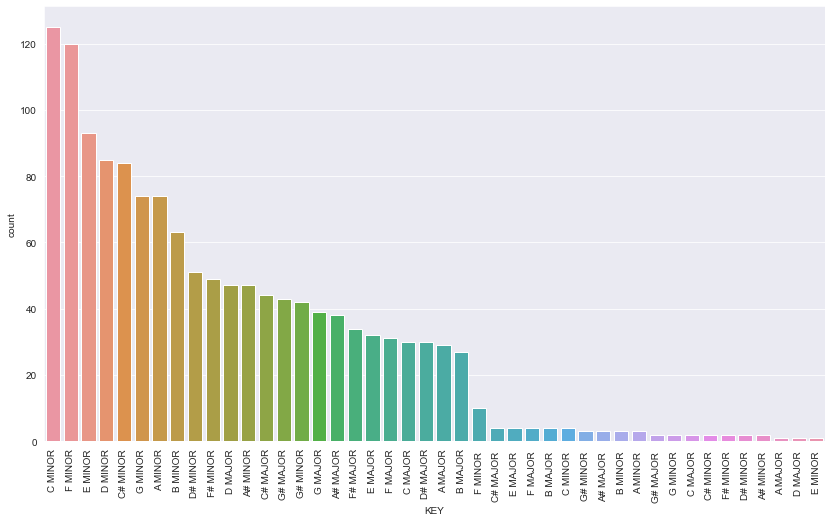

In [17]:
import seaborn as sns
sns.countplot(data=allAnnotations, x="KEY", order=allAnnotations["KEY"].value_counts().index)
plt.xticks(rotation=90)

## Data Processing


### Part 1: Annotation Data Processing


We will assign each key (e.g. `D# minor`) to a unique vector.

Assuming that we only consider major and (natural) minor scales, this means that we can encode each key as a 24 dimensional vector.

In [ ]:
Todo add

### Part 2: Audio Data Processing
